# Input Files for the Model
The notebook contains the code for generating input files for the running the idealized channel model. The files include analytical profiles of forcings, restoration and sponge. A generic topography is also generated.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

import initialization_functions as infs

$\large \text{Read lat-lon grid data}$

In [2]:
ds = xr.open_dataset('../../ocean_monthly_z.static.nc') 

ds

<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    deptho        (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dxt           (yh, xh) float32 ...
    dyCu          (yh, xq) float32 ...
    dyCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolat_u      (yh, xq)

In [3]:
# Define lat and lon limits for the domain
lat = ds['yh'].sel(yh = slice(-70.,-30))
lon = ds['xh'].sel(xh = slice(-280.,-200.)) + 280. # set lon extent to (0, 80.)
dx = ds['dxt'].sel(xh = slice(-280.,-200.), yh = slice(-70.,-30.))
dy = ds['dyt'].sel(xh = slice(-280.,-200.), yh = slice(-70.,-30.))

In [4]:
X,Y = infs.calc_XYmeters_gen(lat, lon, dx, dy, 'yh', 'xh',center_x = True)

$\large \text{Vertical grid and layer densities} $

In [5]:
# Vertical grid
nk = 75
max_depth = 4000.
min_depth = 0.
thkcello_topcell = 1.
method = 'powerlaw'

vgrid = infs.calc_vgrid(nk=nk,max_depth=max_depth,min_depth=min_depth,
                        thkcello_topcell=thkcello_topcell,method=method)

density = xr.open_dataset('../../hycom1_75_800m.nc')
sigma2 = xr.DataArray(density.sigma2.values,coords=[vgrid['NKp1']],dims=['NKp1'])

vgrid = xr.merge([vgrid, sigma2.rename("sigma2")])

#vgrid.to_netcdf('../INPUT/vgrid'+'.nc')

In [8]:
vgrid

<xarray.Dataset>
Dimensions:  (NK: 75, NKp1: 76)
Coordinates:
  * NKp1     (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
  * NK       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
Data variables:
    zw       (NKp1) float64 0.0 1.0 3.787 8.252 ... 3.798e+03 3.898e+03 4e+03
    zt       (NK) float64 0.5 2.393 6.02 11.3 ... 3.748e+03 3.848e+03 3.949e+03
    dz       (NK) float64 1.0 2.787 4.465 6.089 ... 98.04 99.31 100.6 101.8
    sigma2   (NKp1) float64 1.01e+03 1.014e+03 1.018e+03 ... 1.038e+03 1.038e+03

$\large \text{Surface Forcing Files}$ 

Zonally uniform forcing profiles are created for wind stress and surface fluxes. These profiles inspired from SOSEE dataset (see SOSE_Forcing notebook). The general form of the function is
$$f(y) = \sin\left(y + \frac{b}{2}\sin(a\cdot y)\right)^c$$
a, b, c coefficients control the shape and skewness of the profile. Recommended values are a = 1 or 2; b = [-1, 1] and c = 1 or 2.

In [9]:
# Wind Forcing

sponge_width = 1. # In degrees

taux_east = 0.18
taux_west = 0.08
Y0 = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 63.0).argmin()).values # Boundary between ACC/ASF
Lc = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 69.0).argmin()).values # South Zero
sp_wid = (np.max(Y.isel(lonh=0).values) - 
          Y.isel(lonh =0, lath = np.abs(Y.lath.values - np.max(Y.lath.values) + sponge_width).argmin()).values)

wind = xr.Dataset()
wind['taux'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = taux_east, 
                                 max_south = taux_west, a=1., b=0.9, c=1., d=1., e=0, f=2.)

wind['tauy'] = infs.calc_forcing_zonaluniform(Y,function='doublesinusoid_gen',
                                 sponge_width_max = sp_wid,
                                 northsouth_boundary = Y0,
                                 south_zeroregion = Lc, 
                                 max_north = 0., 
                                 max_south = 0., a=1., b=0.9, c=1., d=1., e=0, f=2.)

# Save
wind = wind.transpose('lath','lonh')
wind.to_netcdf('../INPUT/wind'+'.nc')

Buoyancy forcing is set to zero in the code below but, similar to the zonal wind stress profile, the buoyancy forcing terms can be set to have nonzero values. 

In [10]:
# Surface Fluxes

buoyancy = xr.Dataset()
buoyancy['LW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['SW'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['sensible'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['latent'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['evap'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['froz_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_precip'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)
buoyancy['liq_runoff'] = infs.calc_forcing_zonaluniform(Y,function='uniform',uniform_value = 0.0)

# Save
buoyancy = buoyancy.transpose('lath','lonh')
buoyancy.to_netcdf('../INPUT/buoyancy'+'.nc')

This model setup for an equation of state of single variable only, i.e. density is a function of temperature only. Salinity is set to be uniform in the domain. 

In [11]:
# Temperature and salinity initial conditions
Tn = 22
Ts = 0
Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 43.0).argmin()).values
Ws = 1.e6

TS = xr.Dataset()
TS['SST'] = infs.calc_distribution(coordinate = Y, function='tan_hyperbolic', val_at_maxcoord = Tn, 
                                   val_at_mincoord = Ts, Ys = Ys, Ws = Ws)

Sn = 35.
Ss = 35.
Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 43.0).argmin()).values
Ws = 2.5e5

TS['SSS'] = infs.calc_distribution(coordinate = Y, function='uniform',uniform_value = Sn)

# Extend temperature and salinity in the vertical
TS['T'] = (infs.calc_distribution(coordinate=-vgrid.zt, function = 'exponential', val_at_maxcoord = TS['SST']*0.95, efolding = 800) + 
           infs.calc_distribution(coordinate=-vgrid.zt, function = 'linear', val_at_maxcoord = TS['SST']*0.05, val_at_mincoord = TS['SST']*0.025)) 

TS['S'] = infs.calc_distribution(coordinate=-vgrid.zt,function='uniform',uniform_value = Sn)

TS = TS.transpose('NK','lath','lonh')
TS.to_netcdf('../INPUT/TS'+'.nc')

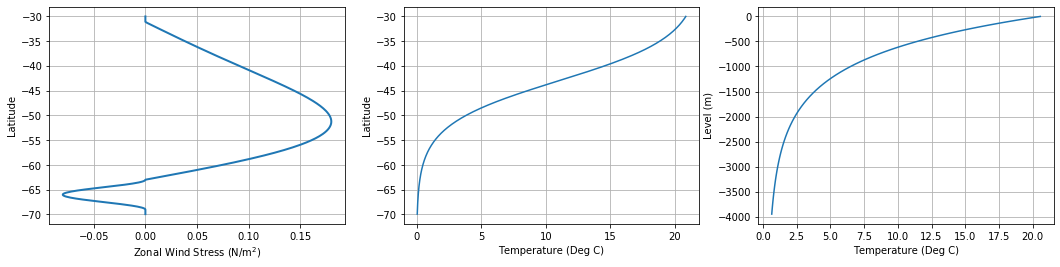

In [12]:
fig = plt.figure(figsize=[18,4])

plt.subplot(1,3,1)
plt.plot(wind['taux'].isel(lonh=0), wind['lath'],lw=2)
plt.grid()
plt.xlabel('Zonal Wind Stress (N/m$^2$)')
plt.ylabel('Latitude')

plt.subplot(1,3,2)
plt.plot(TS['SST'].isel(lonh=0),TS.lath)
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Latitude')
plt.grid()

plt.subplot(1,3,3)
plt.plot(TS['T'].isel(lonh=0).sel(lath=slice(-32,-30)).mean('lath'),-TS.NK)
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Level (m)')
plt.grid()

In [13]:
# Sponge region
sponge_width = [100E3,50E3]
idampval=[1/(7*86400),1/(7*86400)] # Relaxation of 7 days in 100 km width at the northern boundary

sponge = xr.Dataset()
sponge['idamp'] = infs.def_sponge_dampingtimescale_north(Y,sponge_width=sponge_width,idampval=idampval)
sponge['eta'] = infs.def_sponge_interfaceheight(vgrid,Y)

# Add temperature and salinity profile to sponge region
sponge['T'] = TS['T']
sponge['S'] = TS['S']

sponge = sponge.transpose('NKp1','NK','lath','lonh')
sponge.to_netcdf('../INPUT/sponge'+'.nc')

In [69]:
# Topography
max_depth = 4000.

Ys = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 67.0).argmin()).values
min_shelf_depth, shelf_lat, shelf_width = (500., Ys, 2.e5)

d_shelf = (infs.make_topography(function='shelf', H=max_depth, Hs=min_shelf_depth, Y1=Y, 
                                Ys=shelf_lat, Ws=shelf_width))

bump_lat = Y.isel(lonh =0, lath = np.abs(Y.lath.values + 52.).argmin()).values
bump_lon = 0.
bump_width = np.abs(Y.isel(lonh =0, lath = np.abs(Y.lath.values + 46.).argmin()).values -
                    Y.isel(lonh =0, lath = np.abs(Y.lath.values + 58.).argmin()).values)
bump_length = np.abs(X.isel(lath =0, lonh = np.abs(X.lonh.values - 30.).argmin()).values -
                    X.isel(lath =0, lonh = np.abs(X.lonh.values - 50.).argmin()).values)

d_bump = (infs.make_topography(function='bump', Hs=3000., Y1=Y, X1=X, Wx=bump_length, Wy=bump_width,
                              Xs=bump_lon, Ys=bump_lat, dx=2.0, dy=2.0))

topography = xr.Dataset()
height = np.maximum(-d_shelf, d_bump)
topography['depth'] = -1*(-max_depth + height)

topography.transpose('lath','lonh')
topography.to_netcdf('../INPUT/topography'+'.nc')

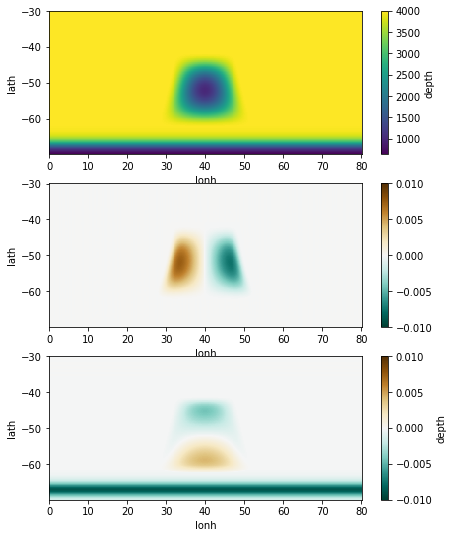

In [70]:
# Topography is a combination of bump (inspired from Kerguelen plateou) and continetal shelf. 
# Topographic gradient magnitudes are close to reality

grady = - topography['depth'].differentiate("lath")*360/(2*np.pi*6378100)
gradx = - topography['depth'].differentiate("lonh")*360/(2*np.pi*6378100*np.cos(Y.lath*np.pi/180.))

fig = plt.figure(figsize=[7,9])

plt.subplot(3,1,1)
topography.depth.plot()

plt.subplot(3,1,2)
gradx.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

plt.subplot(3,1,3)
grady.plot(cmap='BrBG_r',vmin=-1e-2, vmax=1e-2)

In [71]:
ds.close()
density.close()